In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import xarray
data_path = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/projects/photon_calibration/Readout_frequency_152644/dataset.nc"
data = xarray.open_dataset(data_path)
data

<xarray.Dataset>
Dimensions:                            (sample: 100000, sweep_0: 100, sweep_1: 2)
Coordinates:
  * sample                             (sample) int32 0 1 2 ... 99998 99999
    readout_frequency                  (sweep_0) float64 ...
    readout_frequency_if_trans         (sweep_0) int32 ...
    pulse_amplitude_scaling            (sweep_1) float64 ...
    pulse_amplitude_scaling_trans      (sweep_1) float64 ...
Dimensions without coordinates: sweep_0, sweep_1
Data variables:
    readout__final__I__avg             (sweep_1, sweep_0) float64 ...
    readout__final__I__avg__error      (sweep_1, sweep_0) float64 ...
    readout__final__Q__avg             (sweep_1, sweep_0) float64 ...
    readout__final__Q__avg__error      (sweep_1, sweep_0) float64 ...
    readout__final__abs__avg           (sweep_1, sweep_0) float64 ...
    readout__final__abs__avg__error    (sweep_1, sweep_0) float64 ...
    readout__final__phase__avg         (sweep_1, sweep_0) float64 ...
    readout__final__phase__avg__error  (sweep_1, sweep_0) float64 ...
    elapsed_time                       float64 ...
    samples                            int32 ...
Attributes:
    experiment_name:  Readout_frequency
    datetime_start:   2023-07-18-15-26-02
    datetime_end:     2023-07-18-15-26-44
    datetime_format:  year-month-day-hour-minute-second
    data_version:     0.0.2
    qubit_indicies:   0

In [2]:
data.pulse_amplitude_scaling

<xarray.DataArray 'pulse_amplitude_scaling' (sweep_1: 2)>
array([0., 1.])
Coordinates:
    pulse_amplitude_scaling        (sweep_1) float64 0.0 1.0
    pulse_amplitude_scaling_trans  (sweep_1) float64 0.0 1.0
Dimensions without coordinates: sweep_1
Attributes:
    tag:            pulse_amplitude_scaling
    name:           Pulse amplitude scaling
    unit:           V
    sweep_idx:      1
    hardware_loop:  1
    relative:       0
    scale:          0
    transformed:    0
    fixed:          0
    sweep_type:     opx

In [3]:
freq = data.readout_frequency.values * 1e-9
ground = data.readout__final__abs__avg[0, :].values 
ground_err = data.readout__final__abs__avg__error[0, :].values
excited = data.readout__final__abs__avg[1, :].values
excited_err = data.readout__final__abs__avg__error[1, :].values
 

Text(7.555233150893433, 0.0001634409897981305, '$2\\chi = -1.4359 \\pm 0.0398$ MHz')

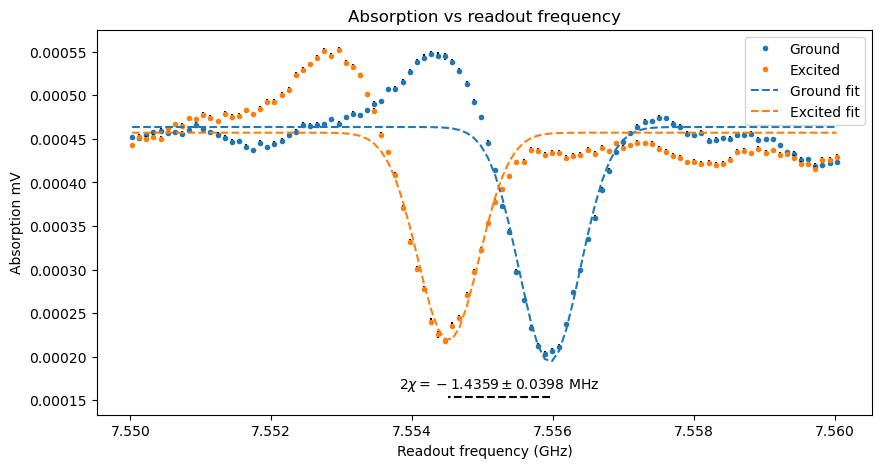

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(freq, ground, yerr=ground_err, fmt="none", color="black")
ax.plot(freq, ground, ".", label="Ground")
ax.errorbar(freq, excited, yerr=excited_err, fmt="none", color="black")
ax.plot(freq, excited, ".", label="Excited")

from scipy.stats import norm

func = lambda x, const, ampltiude, mean, sigma: const - ampltiude * norm.pdf(
    x, mean, sigma
)

from scipy.optimize import curve_fit

val_ground, cov_grond = curve_fit(
    func, freq, ground, sigma=ground_err, p0=[0.005, 0.003, 7.555, 0.001]
)
val_excited, cov_excited = curve_fit(
    func, freq, excited, sigma=excited_err, p0=[0.005, 0.003, 7.555, 0.001]
)

ax.plot(
    freq,
    func(freq, *val_ground),
    label="Ground fit",
    color="C0",
    marker="None",
    ls="--",
)
ax.plot(
    freq,
    func(freq, *val_excited),
    label="Excited fit",
    color="C1",
    marker="None",
    ls="--",
)

ax.set(
    xlabel="Readout frequency (GHz)",
    ylabel="Absorption mV",
    title="Absorption vs readout frequency",
)

ax.legend()

dispersive_shift = val_excited[2] - val_ground[2]
dispersive_shift_err = np.sqrt(cov_excited[2, 2] + cov_grond[2, 2])


ax.hlines(np.min(ground) - 5e-5, val_ground[2], val_excited[2], color="black", ls="--")

ax.text((val_ground[2] + val_excited[2]) / 2, np.min(ground) - 4e-5, f"$2\chi = {1000 * dispersive_shift:.4f} \pm {1000 * dispersive_shift_err:.4f}$ MHz", ha="center")

## Approximate Critical Photon Number

$\chi = g^2 / \Delta$

In [29]:
resonator_frequency = val_ground[2]
qubit_frequency = 5984003878.372194e-9

coupling = np.sqrt( - dispersive_shift / 2 * (resonator_frequency - qubit_frequency))

0.033594035859473834

$n_{crit} = \left(\frac{\Delta}{2g}\right)^2$

In [30]:
n_crit = ((resonator_frequency - qubit_frequency) / coupling / 2) ** 2
n_crit

547.3833208391409